In [6]:
import warnings
warnings.filterwarnings("ignore")

import sys,os

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

import glob
import xarray as xr
import datetime

In [7]:
# import yaml
import tqdm
import torch
import pickle
import logging
import random

from typing import List, Dict, Callable, Union, Any, TypeVar, Tuple
# from multiprocessing import cpu_count


import torch
import torch.fft
from torch import nn

import torch.nn.functional as F

# from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [8]:
# set this up to point to the libararies directory in ml-holodec
dirP_str = os.path.join(os.environ['HOME'], 
                    'Python', 
                    'holodec-ml',
                    'library')
if dirP_str not in sys.path:
    sys.path.append(dirP_str)

In [9]:
import torch_optics_utils as optics

In [10]:
is_cuda = torch.cuda.is_available()
device = torch.device(torch.cuda.current_device()) if is_cuda else torch.device("cpu")

if is_cuda:
    torch.backends.cudnn.benchmark = True

print(f'Preparing to use device {device}')

Preparing to use device cuda:0


# Select Data

In [11]:
data_dir = '/glade/p/cisl/aiml/ai4ess_hackathon/holodec/'

In [12]:
file_list = glob.glob(data_dir+'*.nc')
for f_idx,file in enumerate(file_list):
    print(f'{f_idx}.) '+file.split('/')[-1])

0.) synthetic_holograms_7particle_gamma_600x400_training.nc
1.) synthetic_holograms_10particle_gamma_512x512_validation_patches128x128.nc
2.) synthetic_holograms_50-100particle_bidisperse_test.nc
3.) synthetic_holograms_multiparticle_validation.nc
4.) synthetic_holograms_1particle_training_small.nc
5.) synthetic_holograms_6particle_gamma_600x400_test.nc
6.) synthetic_holograms_multiparticle_training.nc
7.) synthetic_holograms_50-100particle_gamma_private.nc
8.) synthetic_holograms_12-25particle_gamma_600x400_validation.nc
9.) synthetic_holograms_6particle_gamma_600x400_training.nc
10.) synthetic_holograms_50-100particle_gamma_training.nc
11.) synthetic_holograms_1particle_gamma_600x400_training.nc
12.) synthetic_holograms_4particle_gamma_600x400_validation.nc
13.) synthetic_holograms_3particle_validation.nc
14.) synthetic_holograms_10particle_gamma_600x400_test.nc
15.) synthetic_holograms_1particle_gamma_600x400_validation.nc
16.) synthetic_holograms_10particle_gamma_600x400_training.n

In [13]:
f_sel = 37 
dataFile = file_list[f_sel]

In [14]:
h_ds = xr.open_dataset(dataFile)

In [15]:
h_ds

<xarray.Dataset>
Dimensions:  (hologram_number: 100, particle: 50000, xsize: 4872, ysize: 3248)
Dimensions without coordinates: hologram_number, particle, xsize, ysize
Data variables:
    hid      (particle) float32 ...
    d        (particle) float32 ...
    x        (particle) float32 ...
    y        (particle) float32 ...
    z        (particle) float32 ...
    n0       (particle) float32 ...
    mu       (particle) float32 ...
    lam      (particle) float32 ...
    distid   (particle) float32 ...
    image    (hologram_number, xsize, ysize) uint8 ...
Attributes: (12/29)
    DateCreated:           01-Jul-2021
    Nx:                    4872.0
    Ny:                    3248.0
    dx:                    2.96e-06
    dy:                    2.96e-06
    lambda:                3.55e-07
    ...                    ...
    makeRandParts:         1
    should_random:         1
    should_extend_domain:  0
    superSamplingRate:     1.0
    monodisperse:          0.0
    should_cache:          1

Define the tile size and stride

In [16]:
tile_size = 512  # size of tiled images in pixels
step_size = 128  # amount that we shift the tile to make a new tile
marker_size = 10 # UNET gaussian marker width (standard deviation) in um

# step_size is not allowed be be larger than the tile_size
assert tile_size >= step_size

Define the z bin resolution

In [17]:
n_bins = 100  # number of bins in histogram
z_bins = np.linspace(h_ds.attrs['zMin'],h_ds.attrs['zMax'],n_bins+1)*1e6  # histogram bin edges
z_centers = z_bins[:-1] + 0.5*np.diff(z_bins)  # histogram bin centers

## Load physical information about the hologram

In [18]:
dx = h_ds.attrs['dx']      # horizontal resolution
dy = h_ds.attrs['dy']      # vertical resolution
Nx = int(h_ds.attrs['Nx']) # number of horizontal pixels
Ny = int(h_ds.attrs['Ny']) # number of vertical pixels
lam = h_ds.attrs['lambda'] # wavelength
zMin = h_ds.attrs['zMin']  # minimum z in sample volume
zMax = h_ds.attrs['zMax']  # maximum z in sample volume
zCCD = 0                   # z position of the image plane
num_per_holo = 1
image_norm = 255.0

In [19]:
x_arr = np.arange(-Nx//2,Nx//2)*dx
y_arr = np.arange(-Ny//2,Ny//2)*dy

In [20]:
# create the frequency axes on the "device" needed for the reconstruction calculation
fx = torch.fft.fftfreq(Nx,dx,device=device).unsqueeze(0).unsqueeze(2)
fy = torch.fft.fftfreq(Ny,dy,device=device).unsqueeze(0).unsqueeze(1)

In [21]:
# create histogram bins
tile_x_bins = np.arange(-Nx//2,Nx//2,step_size)*dx*1e6
tile_y_bins = np.arange(-Ny//2,Ny//2,step_size)*dy*1e6

Functions to create training data

In [22]:
def get_next_hologram(h_ds,part_per_holo,empt_per_holo,max_holograms=None):
    """
    Generator to build a dataset of hologram patches
    h_ds - xarray dataset of the original hologram
    part_per_holo - number of particles with particles to get from each hologram
    empt_per_holo - number of empty patches to grab from each hologram
    max_holograms - the maximum number of holograms to load
    """
    if max_holograms is None:
        max_holograms = h_ds.dims['hologram_number']
    for h_idx in range(max_holograms):
        sub_label,sub_image,image_index_lst,image_coords,unet_labels = get_reconstructed_sub_images(h_idx,h_ds,part_per_holo,empt_per_holo)
        yield sub_label,sub_image,image_index_lst,image_coords,unet_labels
        

In [32]:
def get_reconstructed_sub_images(h_idx,h_ds,part_per_holo,empt_per_holo):
    """
    Reconstruct a hologram at specific planes to provide training data
    with a specified number of sub images containing and not containing
    particles
    """
    
    # roughly half of the empty cases should be near in focus
    empt_near_cnt = empt_per_holo//2  
    
    # locate particle information corresponding to this hologram
    particle_idx = np.where(h_ds['hid'].values==h_idx+1)
    
    x_part = h_ds['x'].values[particle_idx]
    y_part = h_ds['y'].values[particle_idx]
    z_part = h_ds['z'].values[particle_idx]
    d_part = h_ds['d'].values[particle_idx]  # not used but here it is
    
    # create a 3D histogram 
    in_data = np.stack((x_part,y_part,z_part)).T
    h_part = np.histogramdd(in_data,bins=[tile_x_bins,tile_y_bins,z_bins])[0]
    z_part_bin_idx = np.digitize(z_part,z_bins)-1 # specify the z bin locations of the particles
    
    # smoothing kernel accounts for overlapping subimages when the 
    # subimage is larger than the stride
    if step_size < tile_size:
        overlap_kernel = np.ones((tile_size//step_size,tile_size//step_size))
        for z_idx in range(h_part.shape[-1]):
            h_part[:,:,z_idx] = convolve2d(h_part[:,:,z_idx],overlap_kernel)[tile_size//step_size-1:h_part.shape[0]+tile_size//step_size-1,tile_size//step_size-1:h_part.shape[1]+tile_size//step_size-1]
    
    # locate all the cases where particles are and are not present
    # to sample from those cases
    if step_size < tile_size:
        # note that the last bin is ommitted from each to avoid edge cases where
        # the image is not complete

        edge_idx = tile_size//step_size-1

        # find the locations where particles are in focus
        loc_idx = np.where(h_part[:-edge_idx,:-edge_idx,:] > 0)
        # find locations where particles are not in focus
        empt_idx = np.where(h_part[:-edge_idx,:-edge_idx,:] == 0)
        # find locations where particles are nearly in focus
        zdiff = np.diff(h_part[:-edge_idx,:-edge_idx,:],axis=2)
        zero_pad = np.zeros(h_part[:-edge_idx,:-edge_idx,:].shape[0:2]+(1,))
        near_empt_idx = np.where((h_part[:-edge_idx,:-edge_idx,:] == 0) & ( (np.concatenate([zdiff,zero_pad],axis=2) == 1) | (np.concatenate([zero_pad,zdiff],axis=2) == -1) ) )
    else:
        # find the locations where particles are in focus
        loc_idx = np.where(h_part > 0)
        # find locations where particles are not in focus
        empt_idx = np.where(h_part == 0)
        # find locations where particles are nearly in focus
        zdiff = np.diff(h_part,axis=2)
        zero_pad = np.zeros(h_part.shape[0:2]+(1,))
        near_empt_idx = np.where((h_part == 0) & ( (np.concatenate([zdiff,zero_pad],axis=2) == 1) | (np.concatenate([zero_pad,zdiff],axis=2) == -1) ) )
        
    # select sub images with particles in them
    if part_per_holo > loc_idx[0].size:
        # pick the entire set
        loc_x_idx = loc_idx[0]
        loc_y_idx = loc_idx[1]
        loc_z_idx = loc_idx[2]
    else:
        # randomly select particles from the set
        sel_part_idx = np.random.choice(np.arange(loc_idx[0].size,dtype=int), size=part_per_holo, replace=False)
        loc_x_idx = loc_idx[0][sel_part_idx]
        loc_y_idx = loc_idx[1][sel_part_idx]
        loc_z_idx = loc_idx[2][sel_part_idx]

    # randomly select empties from the empty set
    sel_empt_idx = np.random.choice(np.arange(near_empt_idx[0].size,dtype=int), size=empt_near_cnt, replace=False)  # select nearly in focus cases
    sel_empt_idx = np.concatenate([np.random.choice(np.arange(empt_idx[0].size,dtype=int), size=(empt_per_holo-empt_near_cnt), replace=False),sel_empt_idx])  # select random out of focus cases
    empt_x_idx = empt_idx[0][sel_empt_idx]
    empt_y_idx = empt_idx[1][sel_empt_idx]
    empt_z_idx = empt_idx[2][sel_empt_idx]
    
    # full set of plane indices to reconstruct (empty and with particles)
    z_full_idx = np.unique(np.concatenate((loc_z_idx,empt_z_idx)))
    
    # build the torch tensor for reconstruction
    z_plane = torch.tensor(z_centers[z_full_idx]*1e-6,device=device).unsqueeze(-1).unsqueeze(-1)
    
    # create the torch tensor for propagation
    E_input = torch.tensor(h_ds['image'].isel(hologram_number=h_idx).values).to(device).unsqueeze(0)
    
    # reconstruct the selected planes
    E_out = optics.torch_holo_set(E_input,fx,fy,z_plane,lam).detach().cpu().numpy()
    
    # grab the sub images corresponding to the selected data points
    particle_in_focus_lst = []  # training labels for if particle is in focus
    particle_unet_labels_lst = []  # training labels for if particle is in focus
    image_lst = []  # sliced reconstructed image
    image_index_lst = []  # indices used to identify the image slice
    image_corner_coords = []  # coordinates of the corner of the image slice

    for sub_idx,z_idx in enumerate(z_full_idx):
        part_set_idx = np.where(loc_z_idx == z_idx)[0]
        empt_set_idx = np.where(empt_z_idx == z_idx)[0]
        
        unet_mask = np.zeros(E_out.shape[1:])  # initialize the UNET mask
        part_in_plane_idx = np.where(z_part_bin_idx==z_idx)[0]  # locate all particles in this plane

        # build the UNET mask for this z plane
        for part_idx in part_in_plane_idx:
            unet_mask += np.exp(-(y_arr[None,:]*1e6-y_part[part_idx])**2/(2*marker_size**2) - (x_arr[:,None]*1e6-x_part[part_idx])**2/(2*marker_size**2) )

        for part_idx in part_set_idx:
            x_idx = loc_x_idx[part_idx]
            y_idx = loc_y_idx[part_idx]
            image_lst.append(E_out[sub_idx,x_idx*step_size:(x_idx*step_size+tile_size),y_idx*step_size:(y_idx*step_size+tile_size)])
            image_index_lst.append([x_idx,y_idx,z_idx])
            image_corner_coords.append([x_arr[x_idx*step_size], y_arr[y_idx*step_size]])
            particle_in_focus_lst.append(1)
            particle_unet_labels_lst.append(unet_mask[x_idx*step_size:(x_idx*step_size+tile_size),y_idx*step_size:(y_idx*step_size+tile_size)])

        for empt_idx in empt_set_idx:
            x_idx = empt_x_idx[empt_idx]
            y_idx = empt_y_idx[empt_idx]
            image_lst.append(E_out[sub_idx,x_idx*step_size:(x_idx*step_size+tile_size),y_idx*step_size:(y_idx*step_size+tile_size)])
            image_index_lst.append([x_idx,y_idx,z_idx])
            image_corner_coords.append([x_arr[x_idx*step_size], y_arr[y_idx*step_size]])
            particle_in_focus_lst.append(0)
            particle_unet_labels_lst.append(unet_mask[x_idx*step_size:(x_idx*step_size+tile_size),y_idx*step_size:(y_idx*step_size+tile_size)])
            
    return particle_in_focus_lst, image_lst, image_index_lst, image_corner_coords, particle_unet_labels_lst
    
    

Functions to process holograms operationally

In [19]:
def create_z_plane_lst(z_planes, planes_per_call=1):
    """
    Create a list of z planes according to the requested
    batch size.  This generates the z_planes_lst argument
    needed for gen_next_z_plane()
    """
    z_lst = []
    for z_idx in np.arange(0,z_centers.size,planes_per_call):
        z_lst.append(z_centers[z_idx:(z_idx+planes_per_call)])
    return z_lst

In [20]:
def get_next_z_planes(input_image,z_planes_lst):
    """
    Generator that returns reconstructed z patches
    input_image - 2D image array of the original captured hologam 
    z_planes_lst - list containing batchs of arrays of z positions to reconstruct
        create_z_plane_lst() will provide this for a desired batch size and set
        planes
    
    returns:
        sub_image - list of sub images
        image_index_lst - list of tile indicies to the sub image
        image_coords - x,y corner coordinates of the sub images
        image_z - z location of the sub image in m
    """
    
    z_counter = 0 # the number of planes reconstructed in this generator
    image_tnsr = torch.tensor(input_image,device=device).unsqueeze(0)
    for z_sub_set in z_planes_lst:
        sub_image, image_index_lst, image_coords, image_z, image_pixels = get_sub_images(image_tnsr,z_sub_set,z_counter)
        z_counter+=z_sub_set.size
        yield sub_image, image_index_lst, image_coords, image_z, image_pixels

In [21]:
def get_sub_images(image_tnsr,z_sub_set,z_counter):
    """
    Reconstruct z_sub_set planes from
    the original hologram image and
    split it into tiles of size
    tile_size
    
    image - 3D tensor on device to reconstruct
    z_sub_set - array of z planes to reconstruct in one batch
    z_counter - counter of how many z images have been reconstructed
    
    Returns 
        Esub - a list of complex tiled images 
        image_index_lst - tile index of the sub image (x,y,z)
        image_corner_coords - x,y coordinates of the tile corner (starting values)
        z_pos - the z position of the plane in m
    """
    # build the torch tensor for reconstruction
    z_plane = torch.tensor(z_sub_set*1e-6,device=device).unsqueeze(-1).unsqueeze(-1)
    
    # reconstruct the selected planes
    E_out = optics.torch_holo_set(image_tnsr,fx,fy,z_plane,lam).detach().cpu().numpy()
    
    Esub = []
    z_pos = []
    image_corner_coords = []
    image_index_lst = []
    image_pixel_coords = []

    for z_idx in range(E_out.shape[0]):
        for row_idx in range(0,E_out.shape[1]//step_size):
            if row_idx*step_size+tile_size > E_out.shape[1]:
                image_pixel_x = E_out.shape[1]-tile_size
                row_slice = slice(-tile_size,None)
                row_break = True
            else:
                image_pixel_x = row_idx*step_size
                row_slice = slice(row_idx*step_size,row_idx*step_size+tile_size)
                row_break = False
                    
            for col_idx in range(0,E_out.shape[2]//step_size):
                if col_idx*step_size+tile_size > E_out.shape[2]:
                    image_pixel_y = E_out.shape[2]-tile_size
                    col_slice = slice(-tile_size,None)
                    col_break = True
                else:
                    image_pixel_y = col_idx*step_size
                    col_slice = slice(col_idx*step_size,col_idx*step_size+tile_size)
                    col_break = False
                    
                Esub.append(E_out[z_idx,row_slice,col_slice])
                if Esub[-1].shape != (tile_size,tile_size):
                    print(f"Incorrect image size in tile: {Esub[-1].shape} ")

                z_pos.append(z_sub_set[z_idx]*1e-6)
                image_corner_coords.append([x_arr[row_slice][0], y_arr[col_slice][0]])
                image_index_lst.append([row_idx,col_idx,z_idx+z_counter])
                image_pixel_coords.append([image_pixel_x,image_pixel_y])
                
                if col_break:
                    break
            
            if row_break:
                break
            
    return Esub, image_index_lst, image_corner_coords, z_pos, image_pixel_coords

Operational Data loader for testing

In [33]:
def get_next_z_planes_test(h_ds,h_idx,z_planes_lst):
    """
    Generator that returns reconstructed z patches
    input_image - 2D image array of the original captured hologam 
    z_planes_lst - list containing batchs of arrays of z positions to reconstruct
        create_z_plane_lst() will provide this for a desired batch size and set
        planes
    
    returns:
        sub_image - list of sub images
        image_index_lst - list of tile indicies to the sub image
        image_coords - x,y corner coordinates of the sub images
        image_z - z location of the sub image in m
    """
    
    # locate particle information corresponding to this hologram
    particle_idx = np.where(h_ds['hid'].values==h_idx+1)
    
    x_part = h_ds['x'].values[particle_idx]
    y_part = h_ds['y'].values[particle_idx]
    z_part = h_ds['z'].values[particle_idx]
    d_part = h_ds['d'].values[particle_idx]  # not used but here it is
    
    # create a 3D histogram 
    in_data = np.stack((x_part,y_part,z_part)).T
    h_part = np.histogramdd(in_data,bins=[tile_x_bins,tile_y_bins,z_bins])[0]
    z_part_bin_idx = np.digitize(z_part,z_bins)-1 # specify the z bin locations of the particles
    
    # smoothing kernel accounts for overlapping subimages when the 
    # subimage is larger than the stride
    if step_size < tile_size:
        overlap_kernel = np.ones((tile_size//step_size,tile_size//step_size))
        for z_idx in range(h_part.shape[-1]):
            h_part[:,:,z_idx] = convolve2d(h_part[:,:,z_idx],overlap_kernel)[tile_size//step_size-1:h_part.shape[0]+tile_size//step_size-1,tile_size//step_size-1:h_part.shape[1]+tile_size//step_size-1]
    
    
    input_image = h_ds['image'].isel(hologram_number=h_idx).values
    
    
    z_counter = 0 # the number of planes reconstructed in this generator
    image_tnsr = torch.tensor(input_image,device=device).unsqueeze(0)
    for z_sub_set in z_planes_lst:
        sub_image, image_index_lst, image_coords, image_z, image_pixels, unet_labels, in_focus_labels = \
                get_sub_images_test(image_tnsr, z_sub_set, z_counter, x_part, y_part, z_part, d_part, h_part, z_part_bin_idx)
        z_counter+=z_sub_set.size
        yield sub_image, image_index_lst, image_coords, image_z, image_pixels, unet_labels, in_focus_labels

In [34]:
def get_sub_images_test(image_tnsr,z_sub_set,z_counter, xp, yp, zp, dp, infocus_mask, z_part_bin_idx):
    """
    Reconstruct z_sub_set planes from
    the original hologram image and
    split it into tiles of size
    tile_size
    
    image - 3D tensor on device to reconstruct
    z_sub_set - array of z planes to reconstruct in one batch
    z_counter - counter of how many z images have been reconstructed
    
    Returns 
        Esub - a list of complex tiled images 
        image_index_lst - tile index of the sub image (x,y,z)
        image_corner_coords - x,y coordinates of the tile corner (starting values)
        z_pos - the z position of the plane in m
    """
    # build the torch tensor for reconstruction
    z_plane = torch.tensor(z_sub_set*1e-6,device=device).unsqueeze(-1).unsqueeze(-1)
    
    # reconstruct the selected planes
    E_out = optics.torch_holo_set(image_tnsr,fx,fy,z_plane,lam).detach().cpu().numpy()
    
    Esub = []
    z_pos = []
    image_corner_coords = []
    image_index_lst = []
    image_pixel_coords = []
    unet_sub = []
    in_focus_sub = []

    for z_idx in range(E_out.shape[0]):
        unet_mask = np.zeros(E_out.shape[1:])  # initialize the UNET mask
        part_in_plane_idx = np.where(z_part_bin_idx==z_idx+z_counter)[0]  # locate all particles in this plane

        # build the UNET mask for this z plane
        for part_idx in part_in_plane_idx:
            unet_mask += np.exp(-(y_arr[None,:]*1e6-yp[part_idx])**2/(2*marker_size**2) - (x_arr[:,None]*1e6-xp[part_idx])**2/(2*marker_size**2) )
            
        for row_idx in range(0,E_out.shape[1]//step_size):
            if row_idx*step_size+tile_size > E_out.shape[1]:
                image_pixel_x = E_out.shape[1]-tile_size
                row_slice = slice(-tile_size,None)
                row_break = True
            else:
                image_pixel_x = row_idx*step_size
                row_slice = slice(row_idx*step_size,row_idx*step_size+tile_size)
                row_break = False
                    
            for col_idx in range(0,E_out.shape[2]//step_size):
                if col_idx*step_size+tile_size > E_out.shape[2]:
                    image_pixel_y = E_out.shape[2]-tile_size
                    col_slice = slice(-tile_size,None)
                    col_break = True
                else:
                    image_pixel_y = col_idx*step_size
                    col_slice = slice(col_idx*step_size,col_idx*step_size+tile_size)
                    col_break = False
                    
                Esub.append(E_out[z_idx,row_slice,col_slice])
                unet_sub.append(unet_mask[row_slice,col_slice])
                if Esub[-1].shape != (tile_size,tile_size):
                    print(f"Incorrect image size in tile: {Esub[-1].shape} ")

                z_pos.append(z_sub_set[z_idx]*1e-6)
                image_corner_coords.append([x_arr[row_slice][0], y_arr[col_slice][0]])
                image_index_lst.append([row_idx,col_idx,z_idx+z_counter])
                image_pixel_coords.append([image_pixel_x,image_pixel_y])
                in_focus_sub.append(infocus_mask[row_idx,col_idx,z_idx+z_counter])
                
                if col_break:
                    break
            
            if row_break:
                break
            
    return Esub, image_index_lst, image_corner_coords, z_pos, image_pixel_coords, unet_sub, in_focus_sub

# Demo Data Loader

In [33]:
holo_tiles = get_next_hologram(h_ds,5,5,max_holograms=1)

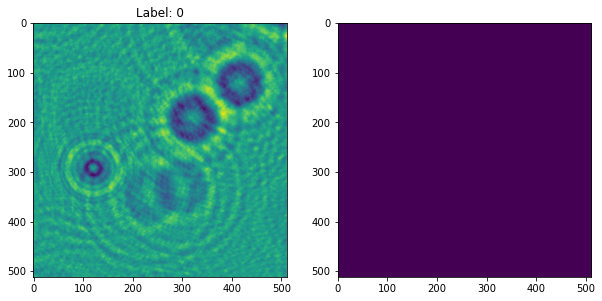

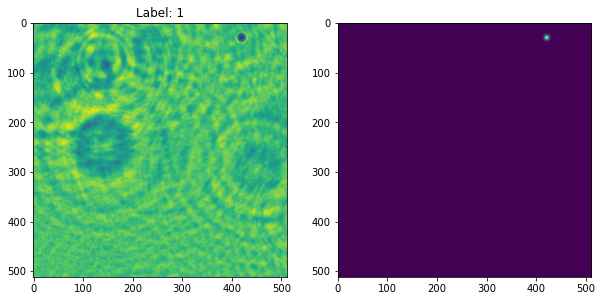

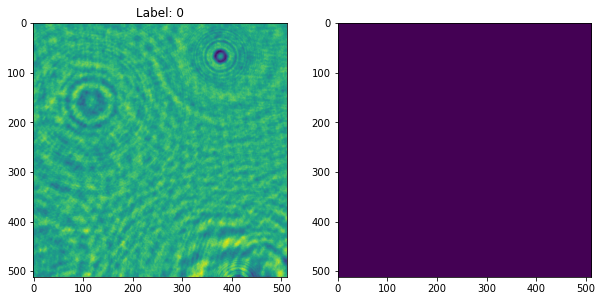

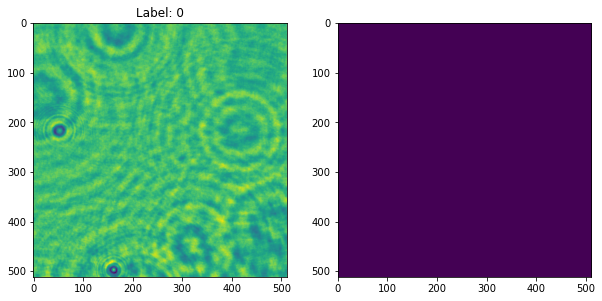

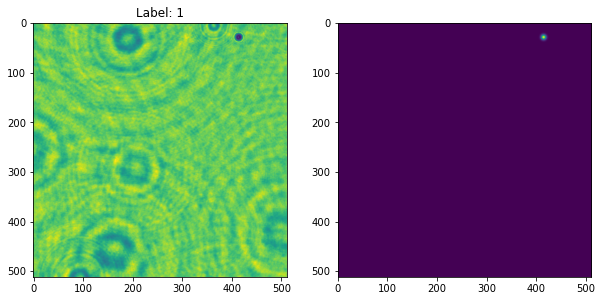

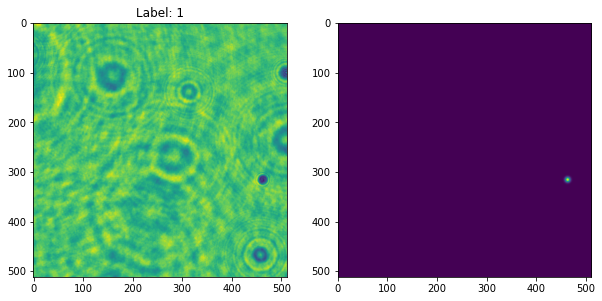

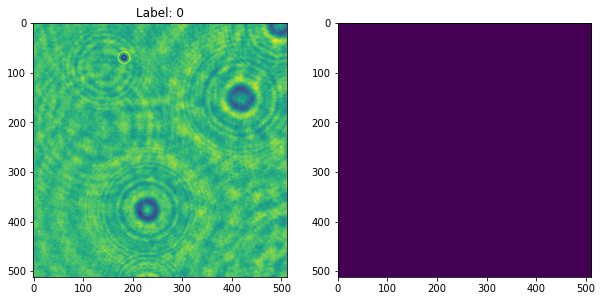

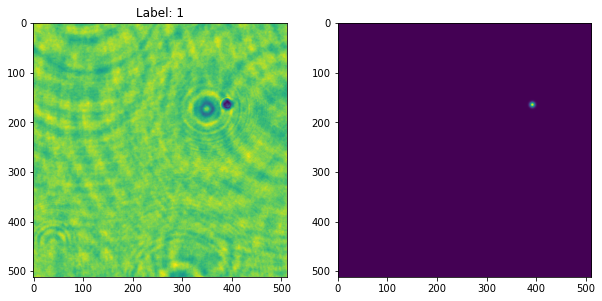

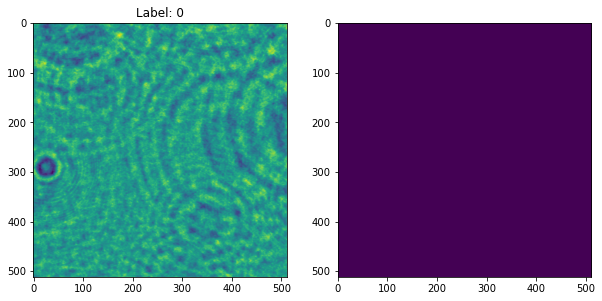

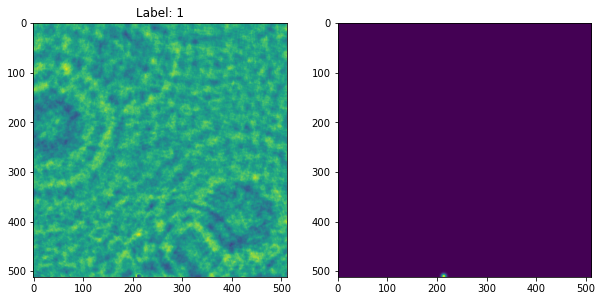

In [34]:
for data in holo_tiles:
    for idx in range(len(data[0])):
        fig,ax = plt.subplots(1,2,figsize=(10,5))
        ax[0].imshow(np.abs(data[1][idx]))
        ax[0].set_title(f"Label: {data[0][idx]}")
        ax[1].imshow(np.abs(data[4][idx]))
    

# Demo Operations Data Loader

In [25]:
h_idx = 34  # hologram index

In [26]:
z_planes_lst = create_z_plane_lst(z_centers, planes_per_call=10)

In [27]:
holo_tiles = get_next_z_planes(h_ds['image'].isel(hologram_number=h_idx).values,z_planes_lst)

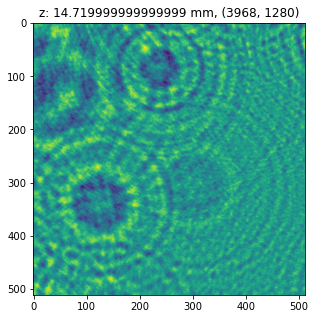

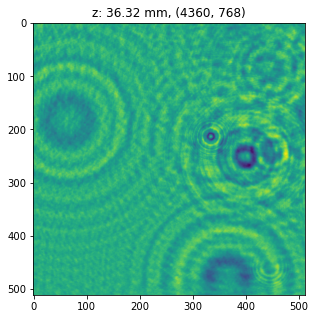

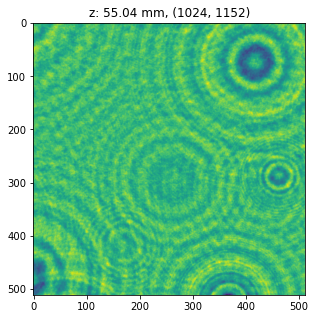

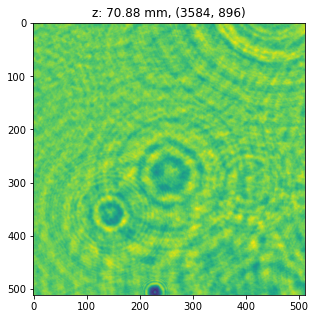

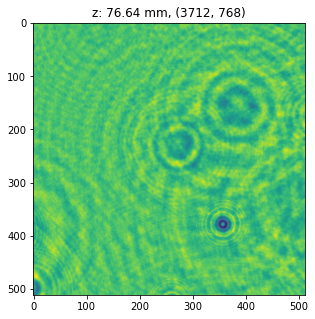

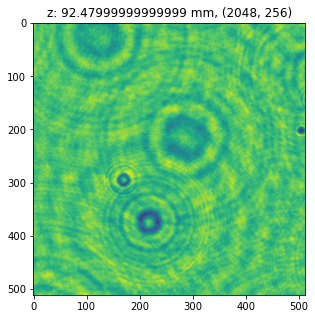

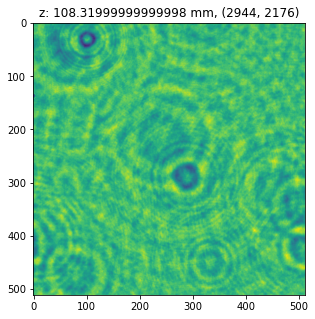

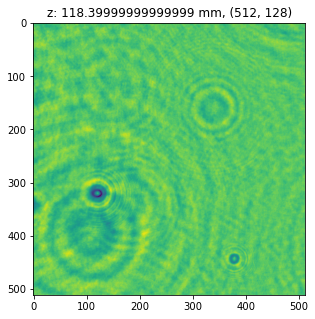

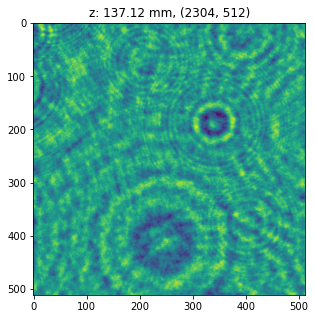

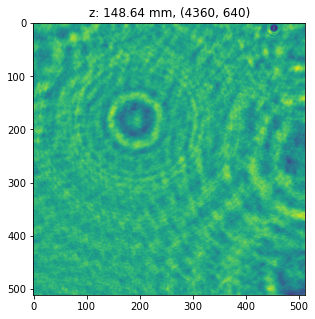

In [28]:
for data in holo_tiles:
#     for idx in range(len(data[0])):
    idx = np.random.choice(np.arange(len(data[0])),size=1,replace=False)[0]
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    ax.imshow(np.abs(data[0][idx]))
    ax.set_title(f"z: {data[3][idx]*1e3} mm, ({data[4][idx][0]}, {data[4][idx][1]})")

# Demo Operations Test Data Loader (returns labels)

In [29]:
h_idx = 34  # hologram index

In [30]:
z_planes_lst = create_z_plane_lst(z_centers, planes_per_call=10)

In [38]:
holo_tiles = get_next_z_planes_test(h_ds,h_idx,z_planes_lst)

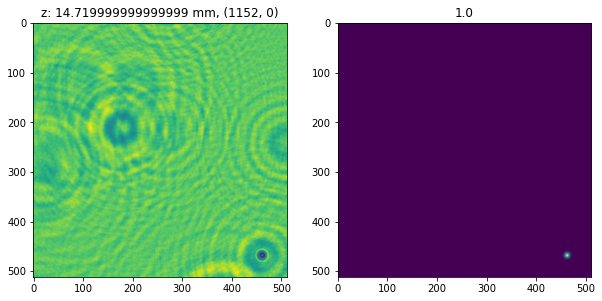

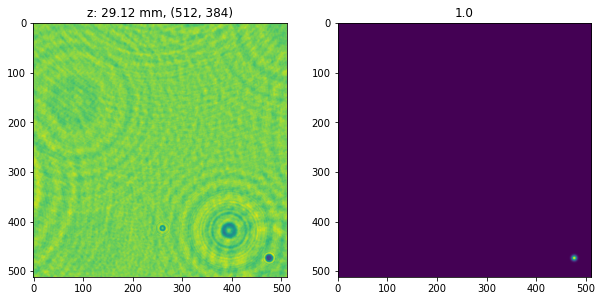

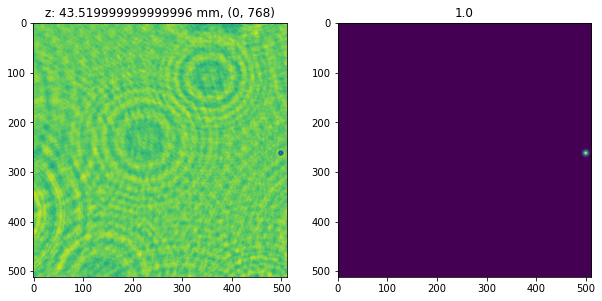

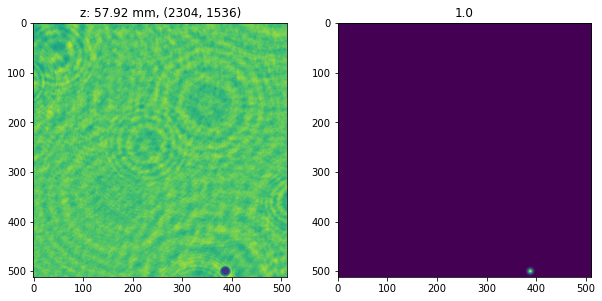

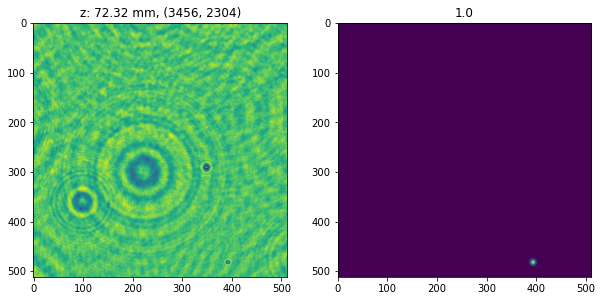

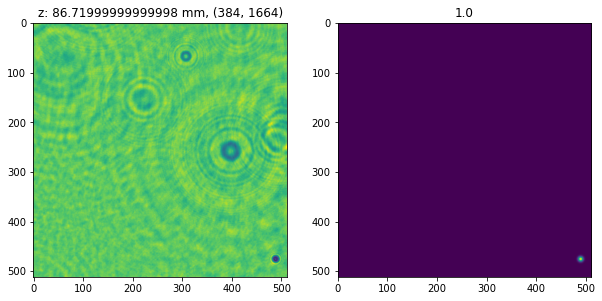

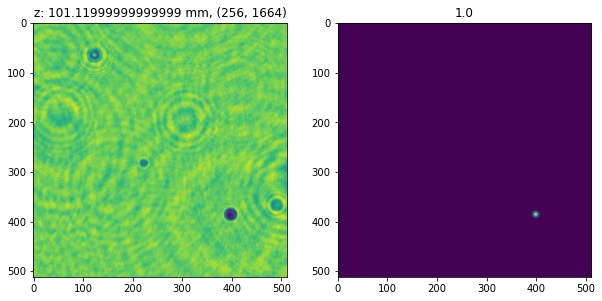

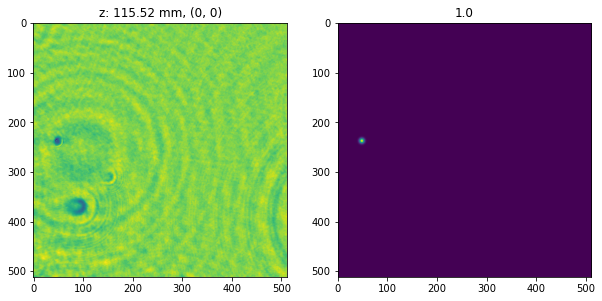

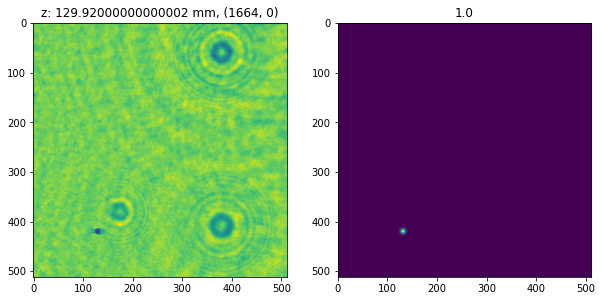

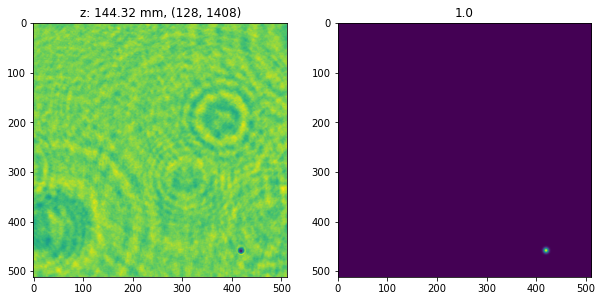

In [39]:
for data in holo_tiles:
#     for idx in range(len(data[0])):
    idx = np.where(data[6]>0)[0][0]  # force plotting infocus particles 
#     idx = np.random.choice(np.arange(len(data[0])),size=1,replace=False)[0]  # plot a random tile
    fig,ax = plt.subplots(1,2,figsize=(10,5))
    ax[0].imshow(np.abs(data[0][idx]))
    ax[0].set_title(f"z: {data[3][idx]*1e3} mm, ({data[4][idx][0]}, {data[4][idx][1]})")
    ax[1].imshow(np.abs(data[5][idx]))
    ax[1].set_title(f"{data[6][idx]}")

# Sandbox Section

In [21]:
h_idx = 10

In [18]:
particle_idx = np.where(h_ds['hid'].values==h_idx+1)

In [19]:
x_part = h_ds['x'].values[particle_idx]
y_part = h_ds['y'].values[particle_idx]
z_part = h_ds['z'].values[particle_idx]
d_part = h_ds['d'].values[particle_idx]  # not used but here it is

Create a 3D histogram

In [20]:
in_data = np.stack((x_part,y_part,z_part)).T

In [21]:
h_part = np.histogramdd(in_data,bins=[tile_x_bins,tile_y_bins,z_bins])[0]

In [22]:
h_part.shape

(38, 25, 100)

In [23]:
# If the sub images are larger than the stride, we need to spread out the positive
# instances in x and y.
if step_size < tile_size:
    overlap_kernel = np.ones((tile_size//step_size,tile_size//step_size))
    for z_idx in range(h_part.shape[-1]):
        h_part[:,:,z_idx] = convolve2d(h_part[:,:,z_idx],overlap_kernel)[tile_size//step_size-1:h_part.shape[0]+tile_size//step_size-1,tile_size//step_size-1:h_part.shape[1]+tile_size//step_size-1] #[:h_part.shape[0],:h_part.shape[1]]  # [tile_size//step_size-1:h_part.shape[0]+tile_size//step_size-1,tile_size//step_size-1:h_part.shape[1]+tile_size//step_size-1]

Find planes with and without particles

In [24]:
part_per_holo = 5  # number of particles to return
empt_per_holo = 5  # number of empties to return

In [25]:
z_part_bin_idx = np.digitize(z_part,z_bins)-1

In [26]:
if step_size < tile_size:
    # note that the last bin is ommitted from each to avoid edge cases where
    # the image is not complete
    
    edge_idx = tile_size//step_size-1

    # find the locations where particles are in focus
    loc_idx = np.where(h_part[:-edge_idx,:-edge_idx,:] > 0)
    # find locations where particles are not in focus
    empt_idx = np.where(h_part[:-edge_idx,:-edge_idx,:] == 0)
else:
    # find the locations where particles are in focus
    loc_idx = np.where(h_part > 0)
    # find locations where particles are not in focus
    empt_idx = np.where(h_part == 0)



In [27]:
# select sub images with particles in them
if part_per_holo > loc_idx[0].size:
    # pick the entire set
    loc_x_idx = loc_idx[0]
    loc_y_idx = loc_idx[1]
    loc_z_idx = loc_idx[2]
else:
    # randomly select particles from the set
    sel_part_idx = np.random.choice(np.arange(loc_idx[0].size,dtype=int), size=part_per_holo, replace=False)
    loc_x_idx = loc_idx[0][sel_part_idx]
    loc_y_idx = loc_idx[1][sel_part_idx]
    loc_z_idx = loc_idx[2][sel_part_idx]
    
# randomly select empties from the set
sel_empt_idx = np.random.choice(np.arange(empt_idx[0].size,dtype=int), size=empt_per_holo, replace=False)
empt_x_idx = empt_idx[0][sel_empt_idx]
empt_y_idx = empt_idx[1][sel_empt_idx]
empt_z_idx = empt_idx[2][sel_empt_idx]

In [31]:
# full set of plane indices to reconstruct
z_full_idx = np.unique(np.concatenate((loc_z_idx,empt_z_idx)))

In [32]:
# build the torch tensor for reconstruction
z_plane = torch.tensor(z_centers[z_full_idx]*1e-6,device=device).unsqueeze(-1).unsqueeze(-1)

In [33]:
# create the torch tensor for propagation
E_input = torch.tensor(h_ds['image'].isel(hologram_number=h_idx).values).to(device).unsqueeze(0)

In [34]:
h_ds['image'].shape[1:]

(4872, 3248)

In [35]:
# reconstruct the selected planes
E_out = optics.torch_holo_set(E_input,fx,fy,z_plane,lam).detach().cpu().numpy()

In [37]:
# grab the sub images corresponding to the selected data points
particle_in_focus_lst = []  # training labels for if particle is in focus
particle_unet_labels_lst = []  # training labels for if particle is in focus
image_lst = []  # sliced reconstructed image
image_index_lst = []  # indices used to identify the image slice
image_corner_coords = []  # coordinates of the corner of the image slice

for sub_idx,z_idx in enumerate(z_full_idx):
    part_set_idx = np.where(loc_z_idx == z_idx)[0]
    empt_set_idx = np.where(empt_z_idx == z_idx)[0]
    
    unet_mask = np.zeros(h_ds['image'].shape[1:])  # initialize the UNET mask
    part_in_plane_idx = np.where(z_part_bin_idx==z_idx)[0]  # locate all particles in this plane
    
    # build the UNET mask for this z plane
    for part_idx in part_in_plane_idx:
        unet_mask += np.exp(-(y_arr[None,:]*1e6-y_part[part_idx])**2/(2*marker_size**2) - (x_arr[:,None]*1e6-x_part[part_idx])**2/(2*marker_size**2) )
    
    # grab the selected image segments with particles
    # in this z plane
    for part_idx in part_set_idx:
        x_idx = loc_x_idx[part_idx]
        y_idx = loc_y_idx[part_idx]
        image_lst.append(E_out[sub_idx,x_idx*step_size:(x_idx*step_size+tile_size),y_idx*step_size:(y_idx*step_size+tile_size)])
        image_index_lst.append([x_idx,y_idx,z_idx])
        image_corner_coords.append([x_arr[x_idx*step_size], y_arr[y_idx*step_size]])
        particle_in_focus_lst.append(1)
        particle_unet_labels_lst.append(unet_mask[x_idx*step_size:(x_idx*step_size+tile_size),y_idx*step_size:(y_idx*step_size+tile_size)])
        
    # grab the selected image segments without particles
    # in this z plane
    for empt_idx in empt_set_idx:
        x_idx = empt_x_idx[empt_idx]
        y_idx = empt_y_idx[empt_idx]
        image_lst.append(E_out[sub_idx,x_idx*step_size:(x_idx*step_size+tile_size),y_idx*step_size:(y_idx*step_size+tile_size)])
        image_index_lst.append([x_idx,y_idx,z_idx])
        image_corner_coords.append([x_arr[x_idx*step_size], y_arr[y_idx*step_size]])
        particle_in_focus_lst.append(0)
        particle_unet_labels_lst.append(unet_mask[x_idx*step_size:(x_idx*step_size+tile_size),y_idx*step_size:(y_idx*step_size+tile_size)])
    

In [247]:
# diagnostic for looking at particles in particular z planes
z_part_bin_idx = np.digitize(z_part,z_bins)-1

In [248]:
loc_z_idx

array([43, 77, 32, 44, 94])

In [249]:
z_centers.shape

(100,)

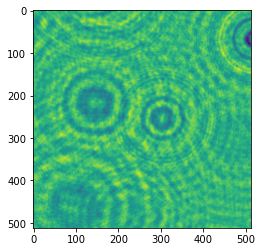

In [250]:
plt.figure()
plt.imshow(np.abs(image_lst[0]))

Label: 1


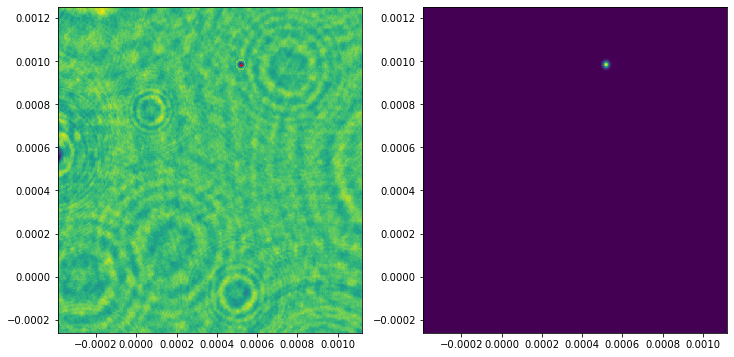

In [44]:
sub_idx = 5
x_sub_arr = np.arange(tile_size)*dx
y_sub_arr = np.arange(tile_size)*dy
plane_idx = image_index_lst[sub_idx][2]

plt_idx = np.where(z_part_bin_idx==plane_idx)[0]


fig,ax = plt.subplots(1,2,figsize=(12,6))
ax[0].pcolormesh(image_corner_coords[sub_idx][0]+x_sub_arr,image_corner_coords[sub_idx][1]+y_sub_arr,np.abs(image_lst[sub_idx]).T)
ax[0].scatter(x_part[plt_idx]*1e-6,y_part[plt_idx]*1e-6,s=2,c='r')
ax[0].set_xlim([image_corner_coords[sub_idx][0],image_corner_coords[sub_idx][0]+x_sub_arr[-1]])
ax[0].set_ylim([image_corner_coords[sub_idx][1],image_corner_coords[sub_idx][1]+y_sub_arr[-1]])

ax[1].pcolormesh(image_corner_coords[sub_idx][0]+x_sub_arr,image_corner_coords[sub_idx][1]+y_sub_arr,particle_unet_labels_lst[sub_idx].T)
ax[1].set_xlim([image_corner_coords[sub_idx][0],image_corner_coords[sub_idx][0]+x_sub_arr[-1]])
ax[1].set_ylim([image_corner_coords[sub_idx][1],image_corner_coords[sub_idx][1]+y_sub_arr[-1]])
# ax.pcolormesh(tile_x_bins*1e-6,tile_y_bins*1e-6,plt_mask.T,alpha=0.3)
print(f"Label: {particle_in_focus_lst[sub_idx]}")

In [252]:
particle_in_focus_lst

[0, 1, 0, 0, 1, 1, 0, 1, 0, 1]

In [253]:
h_ds.dims['hologram_number']

100

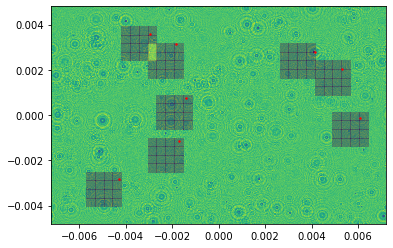

In [254]:
sub_idx = 1

plane_idx = image_index_lst[sub_idx][2]

plt_idx = np.where(z_part_bin_idx==plane_idx)[0]

plt_mask = h_part[:,:,z_full_idx[sub_idx]].copy()
plt_mask[plt_mask == 0] = np.nan

fig,ax = plt.subplots(1,1)
ax.pcolormesh(x_arr,y_arr,np.abs(E_out[sub_idx,:,:]).T)
ax.pcolormesh(tile_x_bins*1e-6,tile_y_bins*1e-6,plt_mask.T,alpha=0.3)
ax.scatter(x_part[plt_idx]*1e-6,y_part[plt_idx]*1e-6,s=2,c='r')
# ax.set_xlim([0.005,0.007])
# ax.set_ylim([0.001,0.003])

In [72]:
E_out.shape

(9, 4872, 3248)

In [75]:
z_full_idx

array([10, 13, 20, 76, 81, 84, 88, 94, 98])

In [108]:
plane_idx = 42

In [109]:
z_plane = torch.tensor([z_centers[plane_idx]*1e-6],device=device).unsqueeze(-1).unsqueeze(-1)

In [110]:
E_input = torch.tensor(h_ds['image'].isel(hologram_number=h_idx).values).to(device).unsqueeze(0)

In [111]:
focus_plane = optics.torch_holo_set(E_input,fx,fy,z_plane,lam).detach().cpu().numpy()

In [112]:
h_full = convolve2d(h_part[0][:,:,plane_idx],overlap_kernel)[:h_part[0].shape[0],:h_part[0].shape[1]]

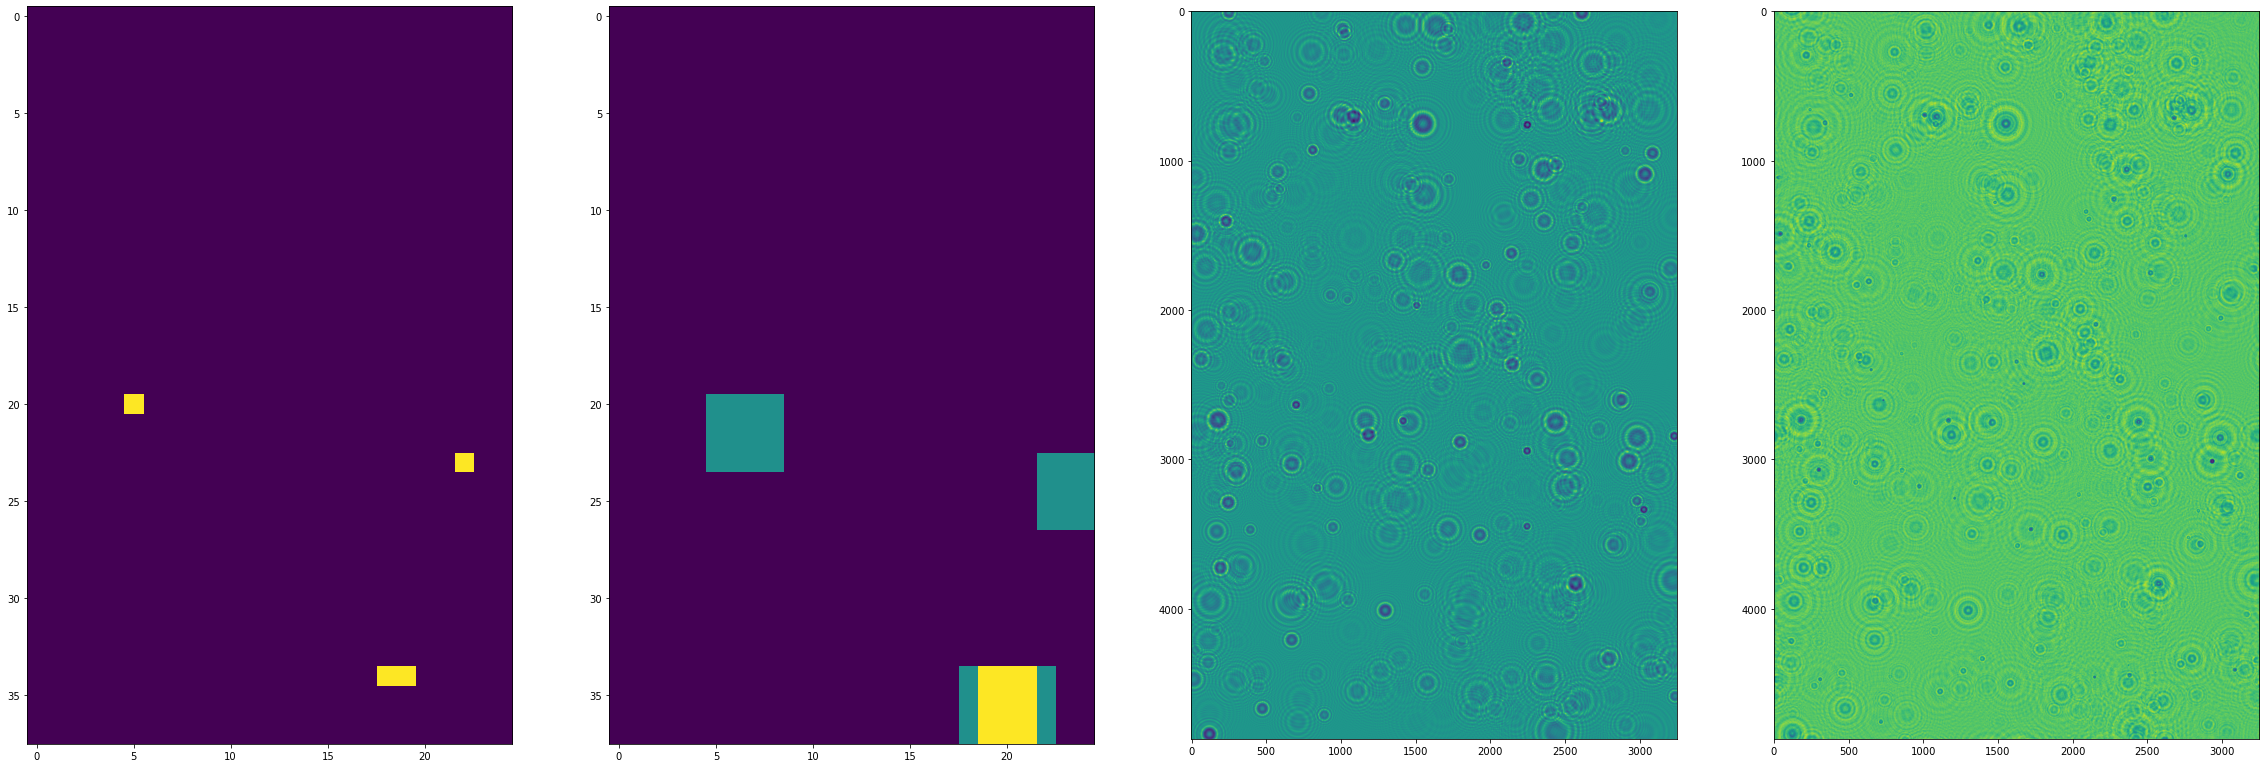

In [113]:
fig,ax = plt.subplots(1,4,figsize=(40,20))
ax[0].imshow(h_part[0][:,:,plane_idx])
ax[1].imshow(h_full)
ax[2].imshow(h_ds['image'].isel(hologram_number=h_idx).values)
ax[3].imshow(np.abs(focus_plane[0,:,:]))

(0.001, 0.003)

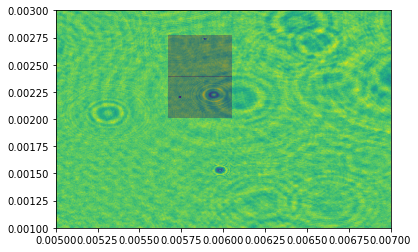

In [117]:
plt_mask = h_part[0][:,:,plane_idx].copy()
plt_mask[plt_mask == 0] = np.nan

fig,ax = plt.subplots(1,1)
ax.pcolormesh(x_arr,y_arr,np.abs(focus_plane[0,:,:]).T)
ax.pcolormesh(tile_x_bins*1e-6,tile_y_bins*1e-6,plt_mask.T,alpha=0.3)
ax.set_xlim([0.005,0.007])
ax.set_ylim([0.001,0.003])

In [ ]:
h, w = arr.shape
np.abs(focus_plane[0,:,:]).reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols)

In [118]:
focus_plane.shape

(1, 4872, 3248)

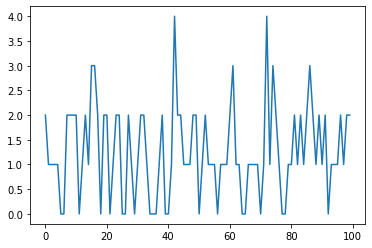

In [31]:
plt.figure()
plt.plot(np.sum(np.sum(h_part[0],axis=0),axis=0))

In [60]:
dx

2.96e-06

In [94]:
focus_plane.shape

(1, 4872, 3248)

Operational Processing sandbox

In [17]:
num_z = 3
z_lst = []
for z_idx in np.arange(0,z_centers.size,num_z):
    z_lst.append(z_centers[z_idx:(z_idx+num_z)])


In [19]:
z_lst[-2]

array([152960., 154400., 155840.])

In [22]:
h_idx = 10

In [23]:
input_image = h_ds['image'].isel(hologram_number=h_idx)

In [24]:
z_lst = create_z_plane_lst(z_centers, planes_per_call=5)

In [29]:
image_tnsr = torch.tensor(input_image.values,device=device).unsqueeze(0)

In [36]:
z_set_idx = 2
# implemented in generator loop
z_counter = 0
for idx in range(z_set_idx):
    z_counter+=len(z_lst[idx])

In [38]:
z_sub_set = z_lst[z_set_idx]

In [39]:
# build the torch tensor for reconstruction
z_plane = torch.tensor(z_sub_set*1e-6,device=device).unsqueeze(-1).unsqueeze(-1)

In [40]:
# reconstruct the selected planes
E_out = optics.torch_holo_set(image_tnsr,fx,fy,z_plane,lam).detach().cpu().numpy()

In [42]:
Esub = []
z_pos = []
image_corner_coords = []
image_index_lst = []

for z_idx in range(E_out.shape[0]):
    for row_idx in range(0,E_out.shape[1]//step_size):
        for col_idx in range(0,E_out.shape[2]//step_size):
            Esub.append(E_out[z_idx,row_idx:row_idx+tile_size,col_idx:col_idx+tile_size])
            z_pos.append(z_sub_set[z_idx])
            image_corner_coords.append([x_arr[row_idx*step_size], y_arr[col_idx*step_size]])
            image_index_lst.append([row_idx,col_idx,z_idx+z_counter])
            

In [33]:
E_out.shape

(5, 4872, 3248)

In [37]:
z_counter

10

In [43]:
Esub[0].shape

(512, 512)

In [45]:
def get_next_z_planes(image_tnsr,z_planes_lst):
    """
    Generator that returns reconstructed z patches
    image - 2D image array of the original captured hologam 
    z_planes_lst - list containing batchs of arrays of z positions to reconstruct
        create_z_plane_lst() will provide this for a desired batch size and set
        planes
    
    returns:
        sub_image - list of sub images
        image_index_lst - list of tile indicies to the sub image
        image_coords - x,y corner coordinates of the sub images
        image_z - z location of the sub image in m
    """
    
    
    z_counter = 0 # the number of planes reconstructed in this generator
    image_tnsr = torch.tensor(input_image.values,device=device).unsqueeze(0)
    for z_sub_set in z_planes_lst:
        sub_image, image_index_lst, image_coords, image_z = get_sub_images(image_tnsr,z_sub_set,z_counter)
        z_counter+=z_sub_set.size
        yield sub_image, image_index_lst, image_coords, image_z

In [46]:
def get_sub_images(image_tnsr,z_sub_set,z_counter):
    """
    Reconstruct z_sub_set planes from
    the original hologram image and
    split it into tiles of size
    tile_size
    
    image - 3D tensor on device to reconstruct
    z_sub_set - array of z planes to reconstruct in one batch
    z_counter - counter of how many z images have been reconstructed
    
    Returns 
        Esub - a list of complex tiled images 
        image_index_lst - tile index of the sub image (x,y,z)
        image_corner_coords - x,y coordinates of the tile corner (starting values)
        z_pos - the z position of the plane in m
    """
    # build the torch tensor for reconstruction
    z_plane = torch.tensor(z_sub_set*1e-6,device=device).unsqueeze(-1).unsqueeze(-1)
    
    # reconstruct the selected planes
    E_out = optics.torch_holo_set(image_tnsr,fx,fy,z_plane,lam).detach().cpu().numpy()
    
    Esub = []
    z_pos = []
    image_corner_coords = []
    image_index_lst = []

    for z_idx in range(E_out.shape[0]):
        for row_idx in range(0,E_out.shape[1]//step_size):
            for col_idx in range(0,E_out.shape[2]//step_size):
                Esub.append(E_out[z_idx,row_idx:row_idx+tile_size,col_idx:col_idx+tile_size])
                z_pos.append(z_sub_set[z_idx]*1e-6)
                image_corner_coords.append([x_arr[row_idx*step_size], y_arr[col_idx*step_size]])
                image_index_lst.append([row_idx,col_idx,z_idx+z_counter])
    return Esub, image_index_lst, image_corner_coords, z_pos

In [44]:
dx

2.96e-06